In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import seaborn as sns
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
import statsmodels.formula.api as smf

from numpy import mean
from numpy import absolute
from numpy import sqrt

from statsmodels.graphics.tsaplots import plot_acf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline
%load_ext autoreload
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set style for plots

In [411]:
sns.set(style="ticks")
sns.set_style("darkgrid")

## Read data from excel

In [412]:
df = pd.read_excel('combat_losses.xlsx', engine='openpyxl')
df = df.set_index('date')

## Quick look at data

In [413]:
df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
date,,,,,,,,,,,,,,
2022-05-26,29600,1315,3235,617,201,93,206,170,2225,13,502,47,4,114
2022-05-27,29750,1322,3246,623,201,93,206,170,2226,13,503,48,4,115
2022-05-28,30000,1330,3258,628,203,93,207,174,2226,13,503,48,4,116
2022-05-29,30150,1338,3270,631,203,93,207,174,2240,13,504,48,4,116
2022-05-30,30350,1349,3282,643,205,93,207,174,2258,13,507,48,4,118


In [414]:
df.columns

Index(['personnel', 'tanks', 'APV', 'artillery systems', 'MLRS',
       'anti-aircraft warfare systems', 'aircraft', 'helicopters', 'vehicles',
       'boats / cutters', 'UAV operational-tactical level',
       'special equipment', 'mobile SRBM system', 'cruise missiles'],
      dtype='object')

In [415]:
df.describe()

,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,763.541667,2010.093750,353.218750,120.354167,59.239583,140.68750,127.437500,1352.489583,7.375000,182.479167,24.083333,2.729167,31.114583
std,371.180391,789.444163,176.035953,57.890092,26.632685,61.63668,44.088144,637.001826,3.937004,171.532104,15.632400,1.860838,46.763879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,473.500000,1482.750000,225.750000,73.500000,44.000000,95.75000,117.250000,938.750000,3.000000,20.000000,11.750000,0.000000,0.000000
50%,735.500000,1955.000000,353.500000,113.000000,63.500000,157.50000,141.500000,1417.500000,7.000000,128.000000,25.000000,4.000000,0.000000
75%,1113.000000,2692.750000,503.750000,171.250000,83.250000,199.00000,155.000000,1928.000000,11.000000,328.250000,38.000000,4.000000,90.000000
max,1349.000000,3282.000000,643.000000,205.000000,93.000000,207.00000,174.000000,2258.000000,13.000000,507.000000,48.000000,4.000000,118.000000


## Functions to handle data approximation
As we see, we have approximate data in personnel losses such as 'less than' or 'more than'.

To handle it we use average losses between 2 war days.

In [416]:
def handle_error(el):
    if str(el)[-1] == '+':
        return 1
    elif str(el)[-1] == '-':
        return -1
    
    return 0

def remove_sign(el):
    if str(el)[-1] in ['+', '-']:
        return int(str(el)[:-1])
    
    return int(el)

def find_error(df):
    n = len(df)

    for i in range(n):
        if df.iloc[i, 0] != remove_sign(df.iloc[i, 0]):
            df.iloc[i, 0] = remove_sign(df.iloc[i, 0]) + handle_error(df.iloc[i, 0]) * ((remove_sign(df.iloc[i+1, 0]) - remove_sign(df.iloc[i, 0])) // 2)


In [417]:
find_error(df)
df = df.fillna(0)
df = df.astype(int)
df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
date,,,,,,,,,,,,,,
2022-05-26,29600,1315,3235,617,201,93,206,170,2225,13,502,47,4,114
2022-05-27,29750,1322,3246,623,201,93,206,170,2226,13,503,48,4,115
2022-05-28,30000,1330,3258,628,203,93,207,174,2226,13,503,48,4,116
2022-05-29,30150,1338,3270,631,203,93,207,174,2240,13,504,48,4,116
2022-05-30,30350,1349,3282,643,205,93,207,174,2258,13,507,48,4,118


## Daily losses
Let's construct a data frame with daily, not total, losses.

In [418]:
daily_df = pd.DataFrame()

daily_df['date'] = df.index
daily_df = daily_df.set_index('date')
daily_df = df.diff().iloc[:, :].fillna(0).astype(int)

## Quick look at daily losses

In [419]:
daily_df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
date,,,,,,,,,,,,,,
2022-05-26,150,10,22,11,0,0,0,0,8,0,11,3,0,2
2022-05-27,150,7,11,6,0,0,0,0,1,0,1,1,0,1
2022-05-28,250,8,12,5,2,0,1,4,0,0,0,0,0,1
2022-05-29,150,8,12,3,0,0,0,0,14,0,1,0,0,0
2022-05-30,200,11,12,12,2,0,0,0,18,0,3,0,0,2


In [420]:
daily_df.iloc[1:, :].describe()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
count,95.000000,95.00000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,319.473684,14.20000,34.547368,6.768421,2.157895,0.978947,2.178947,1.831579,23.768421,0.136842,5.336842,0.505263,0.042105,1.242105
std,337.803822,10.34881,45.956216,7.486801,3.129529,1.529699,2.697434,3.224417,33.345851,0.428022,5.384395,1.327882,0.288643,8.626673
min,50.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,150.000000,8.00000,16.500000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,200.000000,13.00000,26.000000,5.000000,1.000000,0.000000,2.000000,1.000000,17.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,300.000000,16.50000,37.500000,8.500000,3.000000,2.000000,3.000000,2.000000,26.000000,0.000000,8.500000,1.000000,0.000000,0.000000
max,2200.000000,72.00000,410.000000,49.000000,17.000000,8.000000,16.000000,20.000000,261.000000,2.000000,26.000000,10.000000,2.000000,84.000000


In [421]:
ua_columns = ['особовий склад', 'танки', 'бойові броньовані машини', 'артилерійські системи', 'РСЗВ', 'засоби ППО', 'літаки', 'гелікоптери', 'автомобільна техніка', 'кораблі / катери', 'цистерни з ПММ', 'БПЛА оперативно тактичного рівня', 'спеціальна техніка', 'пускові установки ОТРК / ТРК', 'крилаті ракети']

ua_translate = {
    col_en: col_ua for col_en, col_ua in zip(daily_df.iloc[-1, :].index, ua_columns)
}

## Plot data frames
Here we define a function to plot the whole data.

We should put a data frame, size, columns window and benchmark as parameters to tell whether it is Daily or Total df.

In [422]:
interval = len(df) // 8
x_ax = list(map(lambda el: str(el).split()[0], list(df.index)))
x_ticks = list(map(lambda el: el if x_ax.index(el) % interval == 0 or x_ax.index(el) == len(df) -1 else 'inf', x_ax))
x_ticks = sorted(x_ticks, reverse=False)

In [423]:
def draw(df, height, width, end, mark):
    fig, axs = plt.subplots(height, width)

    columns = iter(df.columns[:end])

    for i in range(height):
        for j in range(width):
            col = next(columns)
            axs[i, j].plot(x_ax, df[col])
            axs[i, j].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
            axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axs[i, j].set_xticklabels(x_ticks, rotation=60)
            axs[i, j].set_title(f'{mark} War losses of {col}', fontsize=12)
        
    for col, ax in zip(df.columns, axs.flat):
        ax.set(ylabel=col)

    fig.set_figheight(25)
    fig.set_figwidth(7)

    plt.tight_layout()

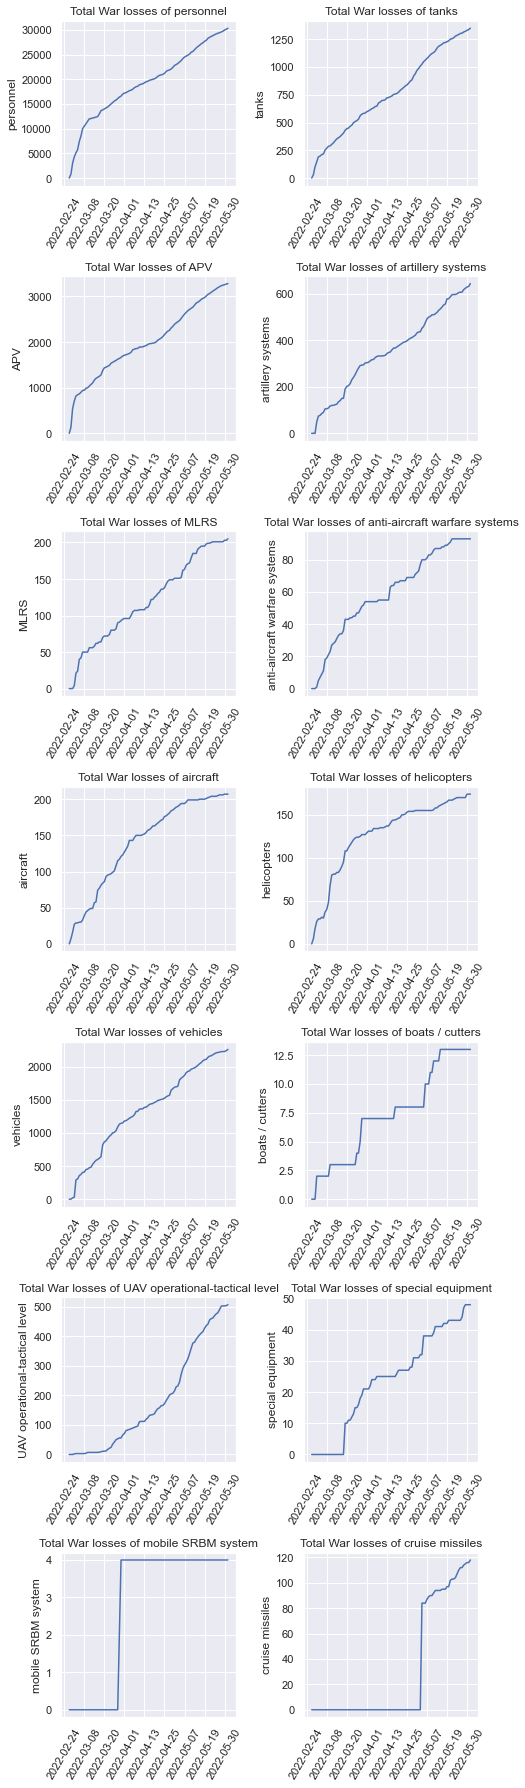

In [424]:
draw(df, 7, 2, len(df), 'Total')

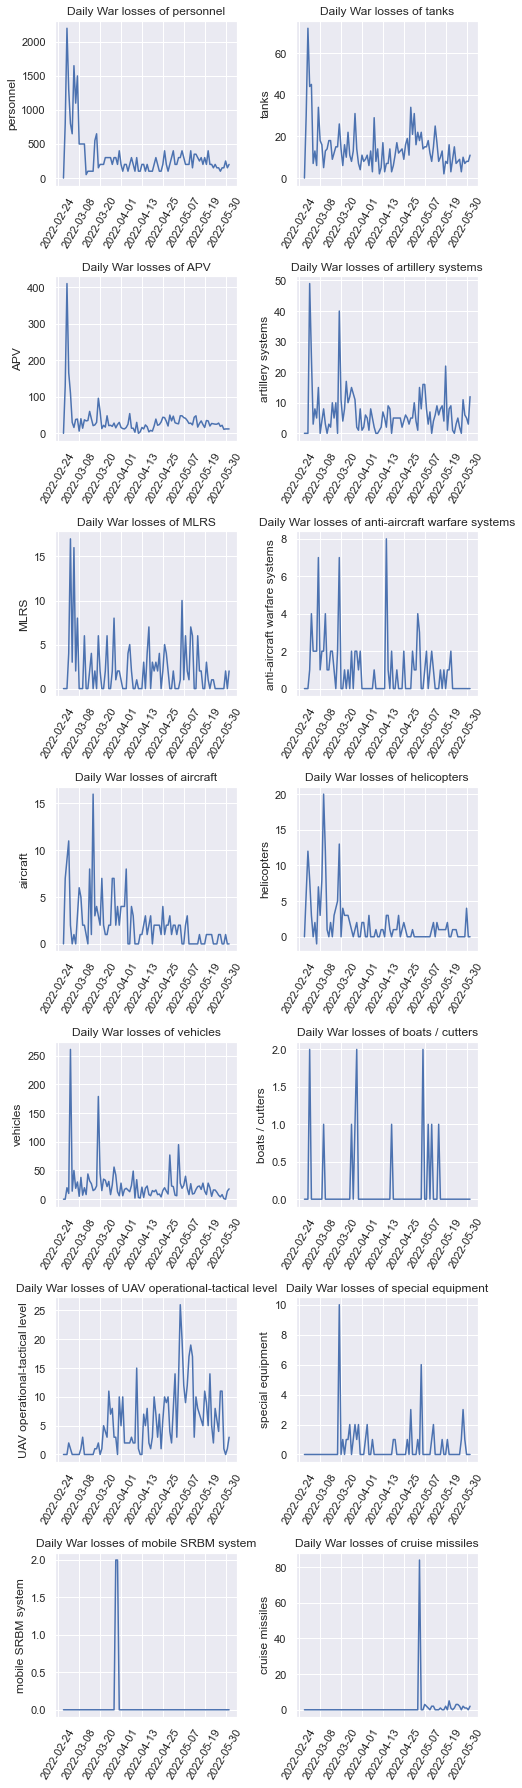

In [425]:
draw(daily_df, 7, 2, len(daily_df), 'Daily')

As we can see, some losses stably grow every day. These are:
* personnel
* tanks
* APV
* artillery systems
* MLRS
* anti-aircraft systems
* aircraft
* helicopters
* vehicles
* UAV operational-tactical level
* special equipment

And a few are rare:
* boats/cutters
* mobile SRBM systems

Data on cruise missles began being collected not so far, so we can't now say whether it is rare or not.

As well, on the plots scales are different, which means that $\mu$ and $\sigma$ of each loss are far away.

## Boxplot
Let's take a look at boxplots of daily losses.

As we mentioned, the scale of features is different and it is quite hard to describe each feature on 1 plot.

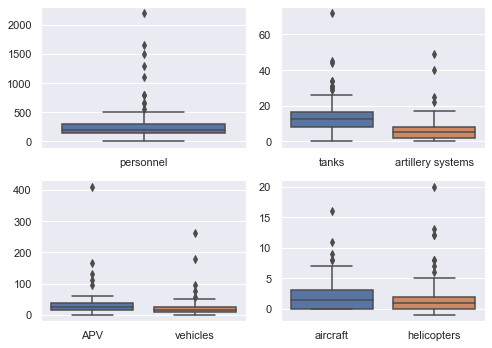

In [426]:
fig, axs = plt.subplots(2, 2)

sns.boxplot(data=daily_df.iloc[:, :1], ax=axs[0, 0])
sns.boxplot(data=daily_df.iloc[:, [1, 3]], ax=axs[0, 1])
sns.boxplot(data=daily_df.iloc[:, [2, 8]], ax=axs[1, 0])
sns.boxplot(data=daily_df.iloc[:, 6:8], ax=axs[1, 1])

fig.set_figheight(5)
fig.set_figwidth(7)

plt.tight_layout()

There are a few outliers and it is explainable. The reason is that in the first week of invasion of Ukraine was concentrated the largest number of the living force and technique, that therefore were destroyed by Ukrainian army.

## Hypothesis testing

Let's conduct 2 hypothesis tests.
<br><br>
**Firstly** we check whether intensity of war actions in first 2 months was larger than in the last 2. Intuitively, intensity in first 2 months should be larger, however, let's check it. We will split our daily data and compare means of 2 distributions. $\mu_1$ is the mean of intensity of first two months, while $\mu_2$ is the mean of intensity of last 2 months.

$H_0: \mu_1 = \mu_2$

$H_1: \mu_1 > \mu_2$

In order to conduct the test of intensity of war actions compared to period Feb-Mar and Apr-May we want to normalize all the losses into 0-1 scale using MinMax normalizing. After that we can create a new feature which is sum of all normalized losses. Here we use a data frame with daily losses.

In [427]:
sc = MinMaxScaler()
normalized_daily_losses = pd.DataFrame(sc.fit_transform(daily_df),
                                        columns=daily_df.columns,
                                        index=daily_df.index)
normalized_daily_losses['intensity'] = normalized_daily_losses.sum(axis=1)

losses_feb_mar = normalized_daily_losses.drop(['cruise missiles', 'mobile SRBM system'],
                                                axis=1).iloc[1:40, :]



losses_apr_may = normalized_daily_losses.drop(['cruise missiles', 'mobile SRBM system'],
                                                axis=1).iloc[40:, :]

We devide **p-value** over 2 to get 1-sided t-test.

In [428]:
ttest, pvalue = stats.ttest_ind(losses_feb_mar['intensity'], losses_apr_may['intensity'])
pvalue /= 2

if pvalue > 0.05:
    print('H_0 holds')
elif ttest > 0:
    print('mu_1 > mu_2')
else:
    print('mu_1 < mu_2')

print(f't-statistics, p-value = ({ttest}, {pvalue})')

mu_1 > mu_2
t-statistics, p-value = (3.514540352723546, 0.00034125776053321657)


Under significance level $\alpha = 0.05$ we can reject null hypotheis that $\mu_1 = \mu_2$. Since t-statistics > 0 –> $\mu_1 - \mu_2 > 0$, we can conclude that intensity in first two months was larger than in the last 2, as was expected.
<br><br><br>
Now let's check whether personnel losses are normally distributed. Since here:
<br><br>
$H_0$: personnel losses $X \sim \mathcal{N}(\mu, \sigma^{2})$

$H_1$: personnel losses $X \neq \mathcal{N}(\mu, \sigma^{2})$

In [429]:
ttest, p_value = stats.shapiro(daily_df.iloc[1:, :]['personnel'])

p_value

7.049625674068836e-15

Under significance level $\alpha = 0.05$ we **can reject** null hypotheis and claim that **personel losses are not normally distributed**.

## Heatmap
Let's take a look at correlation between different losses.

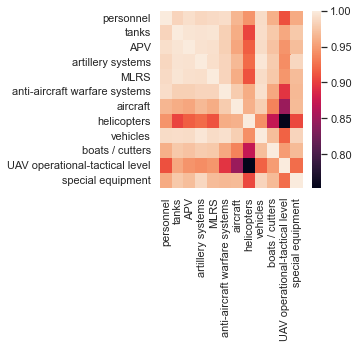

In [430]:
plt.figure(figsize=(5, 5))
sns.heatmap(df.iloc[:, :-2].corr())
plt.tight_layout()

## War duration (in hours)

In [431]:
war_duration_hours = round((pd.to_datetime('today') - df.index[0]) / pd.Timedelta(hours=1), 2)

print(f'War is going on {len(df)} days ({war_duration_hours} hours)')

War is going on 96 days (2294.59 hours)


In [432]:
daily_df.rename(columns={
    'artillery systems': 'artillery_systems',
    'anti-aircraft warfare systems': 'anti_aircraft_warfare_systems',
    'boats / cutters': 'boats_cutters',
    'UAV operational-tactical level': 'UAV_operational_tactical_level',
    'special equipment': 'special_equipment',
    'mobile SRBM system': 'mobile_SRBM_system',
    'cruise missiles': 'cruise_missiles'
}, inplace=True)

## OLS

Here we choose personnel losses being dependent variable and technique with equipments indipendent. We can see, that **tanks, APV, MLRS, vehicles, helicopters and special equipment** influence on **personnel losses**. Since **r-squared** is high enough, having this information the model can explain daily changes of *58.1%* of personnel losses.

In [433]:
formula = 'tanks+APV+MLRS+vehicles'
lm = smf.ols(formula=f'personnel ~ {formula}', data=daily_df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              personnel   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     31.52
Date:                Mon, 30 May 2022   Prob (F-statistic):           1.82e-16
Time:                        14:35:34   Log-Likelihood:                -652.89
No. Observations:                  96   AIC:                             1316.
Df Residuals:                      91   BIC:                             1329.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.1273     41.014      1.393      0.1

## ARIMA model
### Parameters tunning

We choose dead soldires as the object for forecasting. First we need to choose 3 main parameters $p, q, r$ for the ARIMA model.

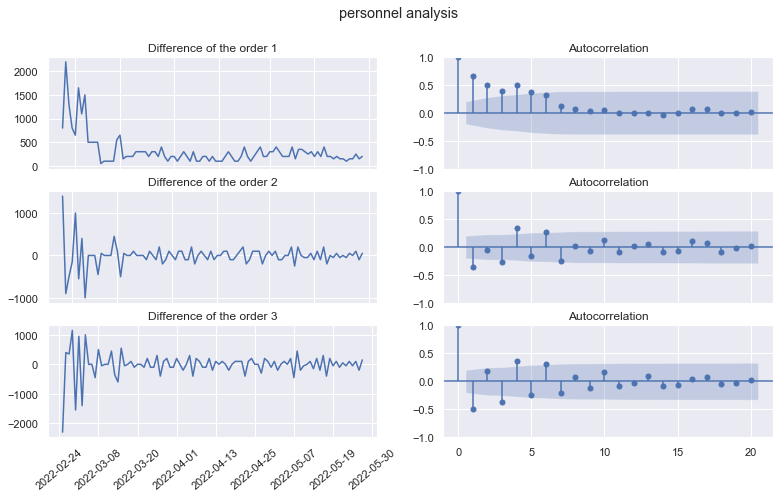

In [434]:
def plot_autocorrelation(d, df, col: str):
    fig, ax = plt.subplots(d, 2)
    new_df = df
    fig.suptitle(col + ' analysis')

    for i in range(d):
        new_df = new_df.diff().dropna()

        ax[i, 0].plot(new_df[col])
        ax[i, 0].set_title(f'Difference of the order {i+1}')
        ax[i, 0].set_xticklabels(['' for _ in range(len(x_ticks))])

        plot_acf(new_df[col], ax=ax[i, 1])
        if i != d-1:
            ax[i, 1].set_xticklabels(['' for _ in range(len(x_ticks))])

    ax[i, 0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i, 0].set_xticklabels(x_ticks, rotation=40)

    fig.set_figheight(7)
    fig.set_figwidth(13)

    plt.show()

plot_autocorrelation(3, df, 'personnel')

In [435]:
def choose_d(df, col: str):
    new_df = df
    print('p-values\n')

    for i in range(1, 4):

        adf_test = adfuller(new_df[col])
        print(f'd={i}\t{adf_test[1]}')
        new_df = new_df.diff().dropna()

choose_d(df, 'personnel')

p-values

d=1	0.4559399308665789
d=2	0.0002875986726639012
d=3	5.855664839036941e-07


Here we see that under significance level $\alpha$ the order of differencing $d = 2$.

$p$, the most significant lag, is 1.

$q$, the number of lags, crossing the threshold is 3.

Therefore we can construct **ARIMA(p=1, d=2, q=3)** model.

Let's take a look at autocorrelation of dependent variables.

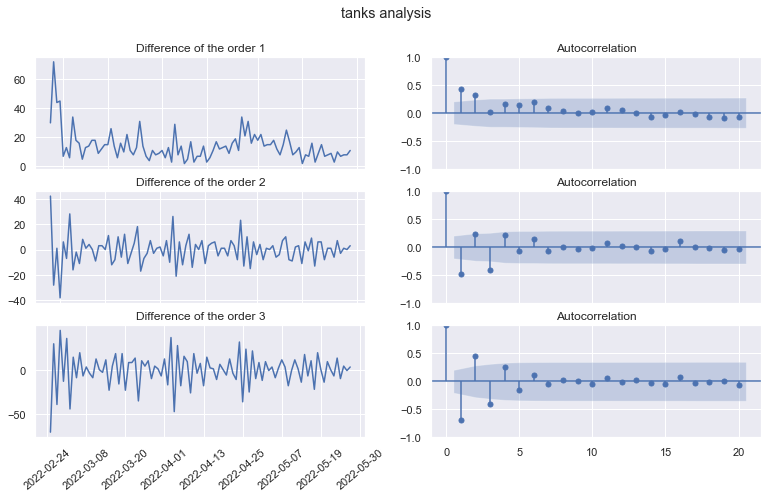

p-values

d=1	0.8916799441427011
d=2	0.00034444082770172487
d=3	8.802197734251913e-14




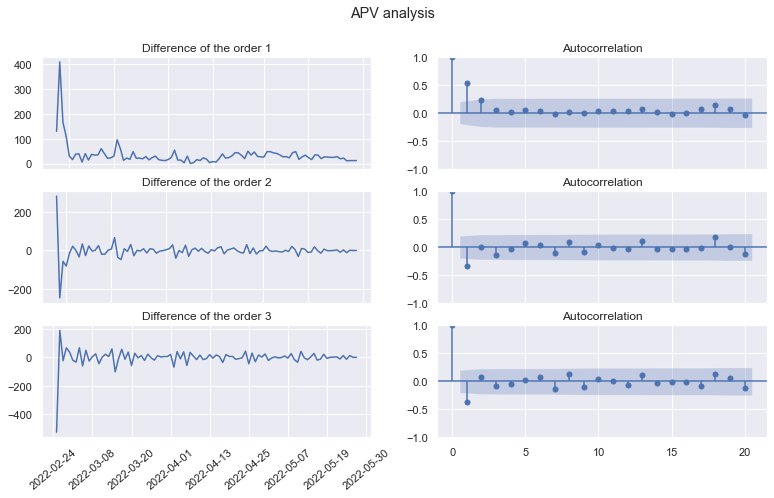

p-values

d=1	0.907760407067262
d=2	1.3632406751467553e-05
d=3	4.884126700110196e-17




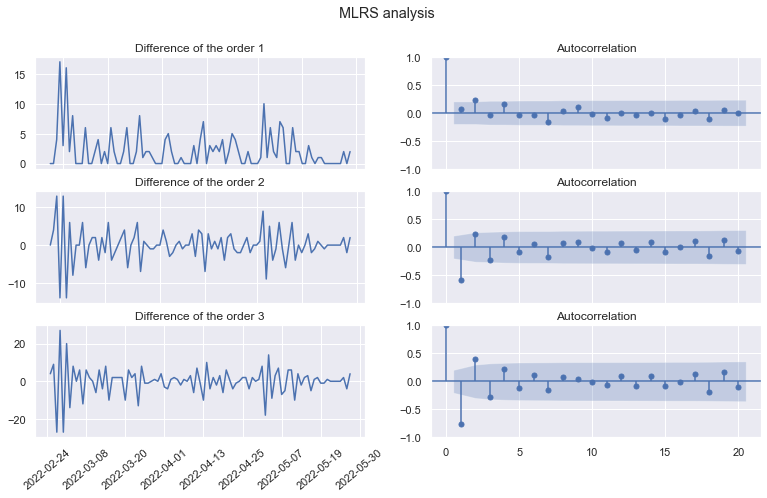

p-values

d=1	0.1294989203500546
d=2	9.456897568963498e-15
d=3	7.833145504201903e-08




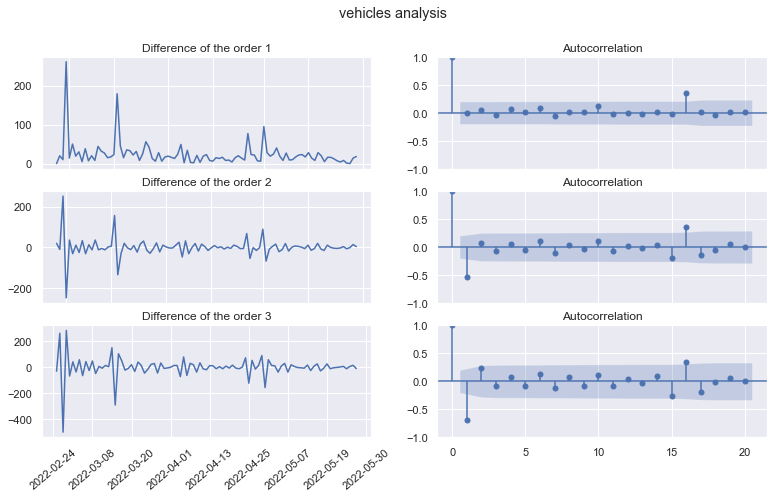

p-values

d=1	0.051857502923919274
d=2	1.4305540609418904e-16
d=3	7.847770861398164e-12




In [436]:
dv = ['tanks', 'APV', 'MLRS', 'vehicles']

for v in dv:
    plot_autocorrelation(3, df, v)
    choose_d(df, v)
    print('\n')

## Model fitting

In [437]:
arima_tanks = ARIMA(df['tanks'], order=(1, 2, 3), freq="D").fit()
arima_apv = ARIMA(df['APV'], order=(1, 2, 2), freq="D").fit()
arima_mlrs = ARIMA(df['MLRS'], order=(1, 2, 2), freq="D").fit()
arima_vehicles = ARIMA(df['vehicles'], order=(1, 2, 3), freq="D").fit()

In [438]:
arima_personnel = ARIMA(df['personnel'], order=(1, 2, 3), freq="D").fit()
print(arima_personnel.summary())

                               SARIMAX Results                                
Dep. Variable:              personnel   No. Observations:                   96
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -637.893
Date:                Mon, 30 May 2022   AIC                           1285.787
Time:                        14:35:41   BIC                           1298.503
Sample:                    02-24-2022   HQIC                          1290.923
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.005   -188.530      0.000      -1.010      -0.990
ma.L1          1.0264      0.105      9.815      0.000       0.821       1.231
ma.L2         -0.4823      0.094     -5.111      0.0

## Prediction curve

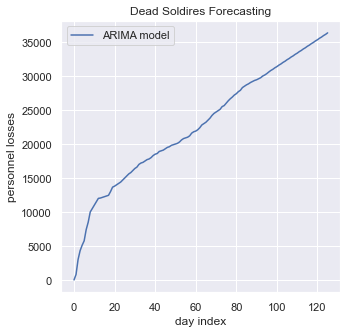

In [439]:
def plot_forecast(*forecastings):
    plt.figure(figsize=(5, 5))

    for forecasting, label in forecastings:
        plt.plot(range(len(forecasting)), forecasting, label=label)

    plt.xlabel('day index')
    plt.ylabel('personnel losses')
    plt.title('Dead Soldires Forecasting')
    plt.legend()
    plt.show()

def forecast_concat(model, df, col: str, days: int):
    y_hat = model.forecast(days).values
    y = df[col].values

    return np.concatenate([y, y_hat])

forecasting = forecast_concat(arima_personnel, df, 'personnel', 30)
plot_forecast((forecasting, 'ARIMA model'))

## Model testing

In order to test our model, we create it based on first $k$ days. We know real values of deaths for the next $n - k$ days. After that we forecast deaths and compute **RMSE, MAE**.

In [440]:
def evaluate(df, col: str, k: int, p, d, q):
    print('\n' + col + ' evaluation\n')
    arima = ARIMA(df[col][:k], order=(p, d, q)).fit()

    y_hat = arima.forecast(len(df) - k).values
    y = df[col][k:].values

    print('MAE:', mean_absolute_error(y, y_hat))
    print('RMSE:', mean_squared_error(y, y_hat, squared=False))
    print('Correlation between real and predicted variables:', np.corrcoef(y_hat, y)[0, 1])
    print('-'* 30)

k = 60

evaluate(df, 'tanks', k, 1, 2, 3)
evaluate(df, 'APV', k, 1, 2, 2)
evaluate(df, 'MLRS', k, 1, 2, 2)
evaluate(df, 'vehicles', k, 1, 2, 3)


tanks evaluation

MAE: 37.83976989993377
RMSE: 42.84477422485016
Correlation between real and predicted variables: 0.981448178177628
------------------------------

APV evaluation

MAE: 63.616883114873154
RMSE: 96.81967796705811
Correlation between real and predicted variables: 0.9933244483685614
------------------------------

MLRS evaluation

MAE: 13.271527173707357
RMSE: 16.747634441386097
Correlation between real and predicted variables: 0.9483865437197382
------------------------------

vehicles evaluation

MAE: 135.86797640889472
RMSE: 143.42435151824188
Correlation between real and predicted variables: 0.9776799045442051
------------------------------


We got good enough errors, which are the indicators, that our model can be used for prediction the number of dead soldires.

## Combination of ARIMA and Linear Regression

Let's try to forecast losses of technique and use it to build linear regression for deaths of soldiers.

In [441]:
predicted_data = []
DAYS = 30

for model in [arima_tanks, arima_apv, arima_mlrs, arima_vehicles]:
    predicted_data.append(list(model.forecast(DAYS).values.astype(int)))

In [442]:
predicted_df = pd.DataFrame(np.array(predicted_data).T, columns=dv)
arima_forecasting = arima_personnel.forecast(DAYS).values.astype(int)


In [443]:
X, y = df[dv], df['personnel']
lr = LinearRegression().fit(X, y)
lr_prediction = lr.predict(predicted_df)

We got 2 different forecasting model for personnel losses. One is purely **ARIMA** model and another one is **linear regression** built on forecasting technique from ARIMA model. Since standard deviations $\sigma$ of forecasting tecnhique are much smaller than the standard deviation $\sigma$ of forecasting personnel losses,linear regression can be more efficient. However, here we need more assumptions to satisfy this efficiency.

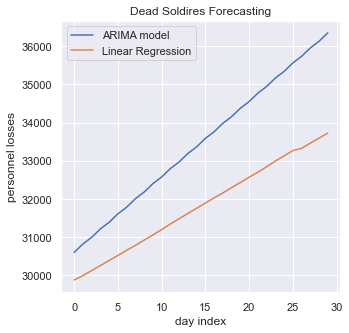

In [444]:
plot_forecast((arima_forecasting, 'ARIMA model'), (lr_prediction, 'Linear Regression'))

## Write obtained results in the csv file

In [445]:
def write_csv(file, forecasting):
    forecasting = forecasting.astype(int)
    data = [[i, y_hat] for i, y_hat in enumerate(forecasting)]

    with open(file, 'w') as f:
        write = csv.writer(f)
        write.writerow(['day index', 'deaths'])
        write.writerows(data)

In [446]:
# write_csv('losses.csv', forecasting)

## Conclusion
During this work we have done exploratory data analysis of russian losses.

Hypothesis testing gives us insights, that in fact, intensity of war actions was larges at the beginning of the invasion. As well, we figured out that personnel losses are not normally distributed.

**OLS** summary provides us information that actually there is a relationship between tecnhique lost and deaths of soldiers.

We constructed **ARIMA** model, in order to forecast personnel and technique losses.

Finally, we combined results of ARIMA forecasting for tecnhique losses and used obtained data to create **Linear Regression** with personnel losses being a dependent variable.

## Data source
General Staff of the Armed Forces of Ukraine
 
https://www.facebook.com/GeneralStaff.ua

## Credits
© Mykhailo-Markiian Tsalyk

https://www.linkedin.com/in/markiian-tsalyk-193758224/